In [1]:

%pprint

Pretty printing has been turned OFF


In [2]:

%run ../../load_magic/storage.py
import re

s = Storage()
w_regex = re.compile(r'\W+')

In [3]:

# https://data.cdc.gov/NCHS/Weekly-Counts-of-Deaths-by-State-and-Select-Causes/3yf8-kanr
weekly_deaths_2018_df = s.load_csv('Weekly_Counts_of_Deaths_by_State_and_Select_Causes__2014-2018')
weekly_deaths_2018_df.columns = [w_regex.sub(' ', cn).strip().replace(' ', '_') for cn in weekly_deaths_2018_df.columns.tolist()]

In [4]:

# https://data.cdc.gov/NCHS/Weekly-Counts-of-Deaths-by-State-and-Select-Causes/muzy-jte6
weekly_deaths_2020_df = s.load_csv('Weekly_Counts_of_Deaths_by_State_and_Select_Causes__2019-2020')
weekly_deaths_2020_df.columns = [w_regex.sub(' ', cn).strip().replace(' ', '_') for cn in weekly_deaths_2020_df.columns.tolist()]

In [15]:

import pandas as pd

all_cases_deaths_df = pd.concat([weekly_deaths_2018_df.groupby(['MMWR_Year', 'MMWR_Week']).All_Cause.sum(),
                                 weekly_deaths_2020_df.groupby(['MMWR_Year', 'MMWR_Week']).All_Cause.sum()])

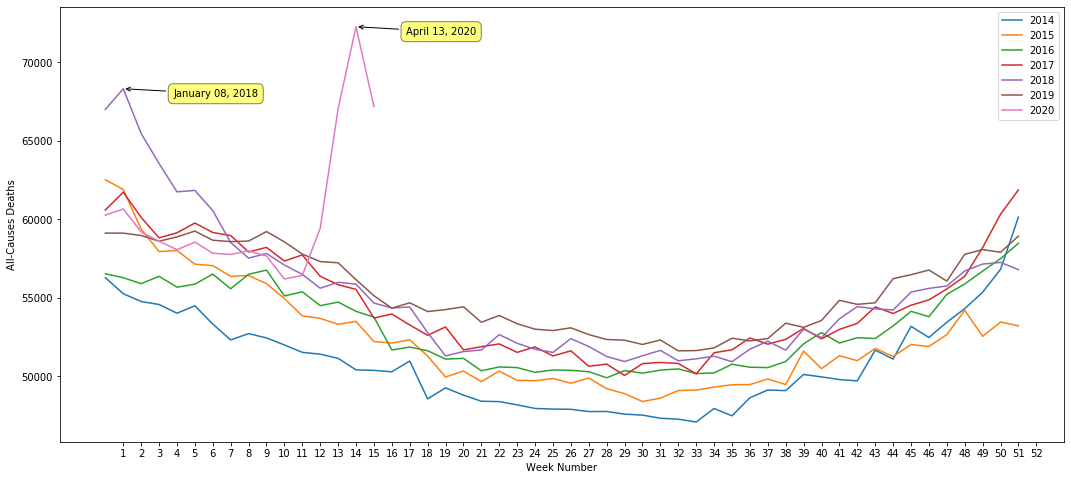

In [6]:

import matplotlib.pyplot as plt
from datetime import datetime

def f(year_series):
    year = year_series.index.get_level_values('MMWR_Year').tolist()[0]
    if (year == 2014):
        mask_series = (year_series.index.get_level_values('MMWR_Week') > 1)
        year_series = year_series[mask_series]
    elif (year == 2020):
        mask_series = (year_series.index.get_level_values('MMWR_Week') < 17)
        year_series = year_series[mask_series]
    year_series.plot.line(ax=ax, label=year)
    
    return year_series.max(), year_series.idxmax()

fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(111, autoscale_on=True)
year_series = all_cases_deaths_df.groupby('MMWR_Year').apply(f)
XTick_obj_list = ax.set_xticks(range(1, 53))
Text_obj_list = ax.set_xticklabels(range(1, 53))
Text_obj = ax.set_xlabel('Week Number')
Text_obj = ax.set_ylabel('All-Causes Deaths')
Legend_obj = ax.legend()
kwargs = dict(textcoords='offset points', ha='left', va='bottom',
              bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
              arrowprops=dict(arrowstyle='->',
                              connectionstyle='arc3,rad=0'))
for y, (year, x) in sorted(year_series.tolist(), reverse=True, key=lambda x: x[0])[:2]:
    date_str = f'{year}-W{x}'
    datetime_obj = datetime.strptime(date_str + '-1', "%Y-W%W-%w")
    label = datetime_obj.strftime('%B %d, %Y')
    annotation = plt.annotate(f'{label}', xy=(x-1, y), xytext=(50, -10), **kwargs)


Prior work has placed estimates for the serial interval of seasonal influenza at 3.6 days (Cowling et al., 2009) with a SD of 1.6 days. Other work has estimated that the serial interval is between 2.8 and 3.3 days (White and Pagano, 2008a).

For the original data we find a dominant frequency of 0.4, suggesting a serial interval of 2.5 days. Repeating this with the imputed data suggests a serial interval of 2.67 days, and the augmented data suggests a serial interval of 3.2 days. These results are similar to the findings on the modal serial interval (3 days) from maximum likelihood estimation, though slightly higher than the estimated mean serial interval (https://www.nap.edu/read/12799/chapter/8#201).

In [247]:

from datetime import date, timedelta

def monday_of_calenderweek(year, week):
    first = date(year, 1, 1)
    base = 1 if first.isocalendar()[1] == 1 else 8
    return first + timedelta(days=base - first.isocalendar()[2] + 7 * (week - 1))

monday_of_calenderweek(2014, 52), monday_of_calenderweek(2014, 53)

(datetime.date(2014, 12, 22), datetime.date(2014, 12, 29))

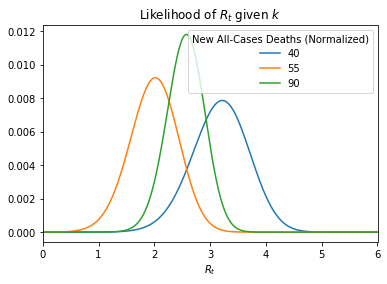

In [282]:

import numpy as np
from scipy import stats as sps

start_mask_series = (all_cases_deaths_df.index.get_level_values('MMWR_Year') == 2014)
start_mask_series = start_mask_series & (all_cases_deaths_df.index.get_level_values('MMWR_Week') <= 1)
end_mask_series = (all_cases_deaths_df.index.get_level_values('MMWR_Year') == 2020)
end_mask_series = end_mask_series & (all_cases_deaths_df.index.get_level_values('MMWR_Week') >= 10)
over_mask_series = (all_cases_deaths_df.index.get_level_values('MMWR_Week') > 52)
mask_series = start_mask_series | end_mask_series | over_mask_series
df = all_cases_deaths_df[~mask_series]
df.index = pd.Index([monday_of_calenderweek(year, week) for (year, week) in df.index])
df.index.name = 'date'
value_counts_series = df.index.value_counts()
mask_series = (value_counts_series > 1)
if value_counts_series[mask_series].shape[0] > 0:
    print(value_counts_series[mask_series])

k = np.array([20, 40, 55, 90])

# NewValue = (((OldValue - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin
def get_new_value(old_value):
    old_min = df.min()
    new_max = 100
    new_min = 0
    old_max = df.max()
    new_value = (((old_value - old_min) * (new_max - new_min)) / (old_max - old_min)) + new_min
    
    return int(new_value)

# We create an array for every possible value of Rt
R_T_MAX = get_new_value(df.max())
r_t_range = np.linspace(get_new_value(df.min()), R_T_MAX, R_T_MAX*100+1)
r_t_range = np.array([round(x, 2) for x in r_t_range])

# Gamma is 1/serial interval
# https://www.nap.edu/read/12799/chapter/8#201
GAMMA = 1/3.2

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

# Plot it
ax = pd.DataFrame(
    data = likelihood_r_t,
    index = r_t_range
).plot(
    title='Likelihood of $R_t$ given $k$',
    xlim=(0, 6)
)

ax.legend(labels=k[1:], title='New All-Cases Deaths (Normalized)')
ax.set_xlabel('$R_t$');

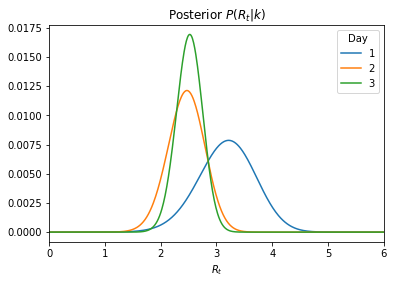

In [249]:

posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

ax = posteriors.plot(
    title='Posterior $P(R_t|k)$',
    xlim=(0, 6)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$');

In [250]:

most_likely_values = posteriors.idxmax(axis=0)
most_likely_values

Day
1    3.22
2    2.47
3    2.52
dtype: float64

In [251]:

def highest_density_interval(pmf, p=.9):
    
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    if len(lows) > 0 and len(highs) > 0:
        best = (highs - lows).argmin()

        low = pmf.index[lows[best]]
        high = pmf.index[highs[best]]

        return pd.Series([low, high],
                         index=[f'Low_{p*100:.0f}',
                                f'High_{p*100:.0f}'])
    else:

        return pd.Series([0.0, 0.0],
                         index=[f'Low_{p*100:.0f}',
                                f'High_{p*100:.0f}'])

hdi = highest_density_interval(posteriors)
hdi.tail()

,Low_90,High_90
Day,,
1,2.29,3.97
2,1.87,2.96
3,2.10,2.88


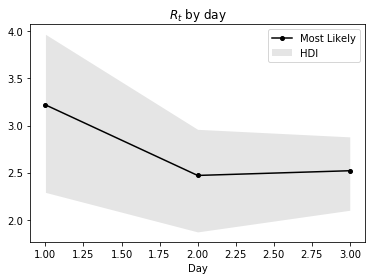

In [252]:

ax = most_likely_values.plot(marker='o',
                             label='Most Likely',
                             title=f'$R_t$ by day',
                             c='k',
                             markersize=4)

ax.fill_between(hdi.index,
                hdi['Low_90'],
                hdi['High_90'],
                color='k',
                alpha=.1,
                lw=0,
                label='HDI')

ax.legend();

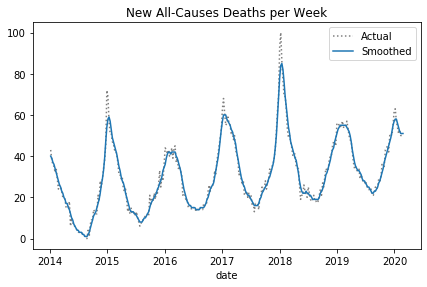

In [253]:

def prepare_cases(cases):
    cases = cases.map(lambda x: get_new_value(x))

    smoothed = cases.rolling(6,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    return cases, smoothed

cases = df.rename('all-causes deaths')

original, smoothed = prepare_cases(cases)

original.plot(title='New All-Causes Deaths per Week', c='k',
              linestyle=':', alpha=.5, label='Actual',
              legend=True, figsize=(500/72, 300/72))

ax = smoothed.plot(label='Smoothed', legend=True)

ax.get_figure().set_facecolor('w')

In [254]:

def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0
    
    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

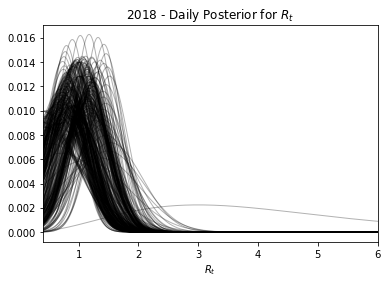

In [255]:

ax = posteriors.plot(title=f'{year} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4, 6.0))

ax.set_xlabel('$R_t$');

In [256]:

# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low_90,High_90
date,,,
2020-01-27,0.94,0.43,1.37
2020-02-03,0.91,0.41,1.36
2020-02-10,0.92,0.42,1.38
2020-02-17,0.95,0.43,1.40
2020-02-24,0.97,0.45,1.42


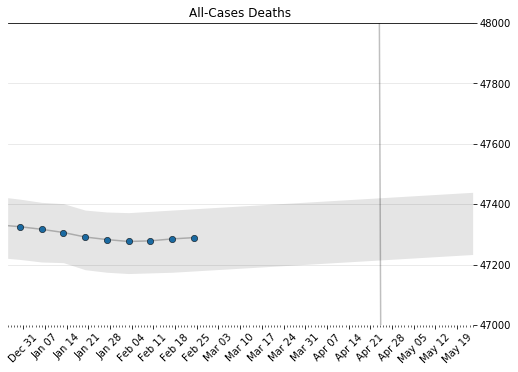

In [285]:

from scipy.interpolate import interp1d
from matplotlib.dates import date2num
from matplotlib import dates as mdates
from matplotlib import ticker

index = result['ML'].index
def get_new_value(old_value):
    new_min = df.min()
    old_max = 100
    old_min = 0
    new_max = df.max()
    new_value = (((old_value - old_min) * (new_max - new_min)) / (old_max - old_min)) + new_min
    
    return new_value
values = result['ML'].map(get_new_value).values

fig, ax = plt.subplots(figsize=(600/72, 400/72))

# Plot dots and line
ax.plot(index, values, c='k', zorder=1, alpha=.25)
ax.scatter(index,
           values,
           s=40,
           lw=.5,
           edgecolors='k', zorder=2)

# Aesthetically, extrapolate credible interval by 90 days either side
lowfn = interp1d(date2num(index),
                 result['Low_90'].map(get_new_value).values,
                 bounds_error=False,
                 fill_value='extrapolate')

highfn = interp1d(date2num(index),
                  result['High_90'].map(get_new_value).values,
                  bounds_error=False,
                  fill_value='extrapolate')

extended = pd.date_range(start=result.index.max()-pd.Timedelta(days=60),
                         end=index[-1]+pd.Timedelta(days=90))

ax.fill_between(extended,
                lowfn(date2num(extended)),
                highfn(date2num(extended)),
                color='k',
                alpha=.1,
                lw=0,
                zorder=3)


# Add back in the missing all-cases deaths
end_mask_series = (all_cases_deaths_df.index.get_level_values('MMWR_Year') == 2020)
end_mask_series = end_mask_series & (all_cases_deaths_df.index.get_level_values('MMWR_Week') >= 10)
extra_df = all_cases_deaths_df[end_mask_series]
extra_df.index = pd.Index([monday_of_calenderweek(year, week) for (year, week) in extra_df.index])
extra_df.index.name = 'date'
index = extra_df.index
values = extra_df.values
ax.plot(index, values, c='k', zorder=1, alpha=.25)
ax.scatter(index,
           values,
           s=40,
           lw=.5,
           edgecolors='k', zorder=2)

# Formatting
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_minor_locator(mdates.DayLocator())

#ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
#ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
ax.yaxis.tick_right()
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.margins(0)
ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
ax.margins(0)
ax.set_ylim(47_000, 48_000)
ax.set_xlim(result.index.max()-pd.Timedelta(days=60), result.index[-1]+pd.Timedelta(days=90))
fig.set_facecolor('w')
ax.set_title('All-Cases Deaths')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45);


----

http://18.216.124.216:3838/COVID-Tracker/

http://basemap.nationalmap.gov/arcgis

http://basemap.nationalmap.gov/arcgis/rest/services

http://dbpedia.org/page/Autauga_County%2C_Alabama

http://docs.python-requests.org/en/master/user/intro/

http://en.wikipedia.org/wiki/User:Gringer/perlshaper

http://matplotlib.org/basemap/

http://matplotlib.org/basemap/users/mapsetup.html

http://matrix.msu.edu/~johnsnow/images/online_companion/chapter_images/fig12-5.jpg

http://server.arcgisonline.com/ArcGIS/rest/services

http://spatialreference.org

http://spatialreference.org/ref/sr-org/6864/

http://www.arcgis.com/features/

http://www.roitsystems.com/

http://www.twitter.com/adamlerer/

http://www.twitter.com/fdellaert/

http://www.usa.com/rank/us--average-temperature--state-rank.htm

http://www.usgs.gov

http://www.w3.org/1999/xlink

http://www.w3.org/2000/svg

https://camo.githubusercontent.com/2a67dd5e2519caebc8d8412b1d7239fe05b9d621/68747470733a2f2f72656164746865646f63732e6f72672f70726f6a656374732f77696b69646174612f62616467652f3f76657273696f6e3d6c6174657374

https://camo.githubusercontent.com/370317e2c78f5691192c1fd8442ae9e47d7a20b6/68747470733a2f2f7472617669732d63692e6f72672f73697a6e61782f7770746f6f6c732e7376673f6272616e63683d6d6173746572

https://camo.githubusercontent.com/45483183eb370ee3df4e21395712335fa08fd7fe/68747470733a2f2f7472617669732d63692e6f72672f6461686c69612f77696b69646174612e737667

https://camo.githubusercontent.com/54b9f92c81a474f90d3ecf4d181241a7d60ab3ff/68747470733a2f2f636f766572616c6c732e696f2f7265706f732f6769746875622f73697a6e61782f7770746f6f6c732f62616467652e7376673f6272616e63683d6d6173746572

https://camo.githubusercontent.com/550c8b4c8b68bc47b819c4ca1f06c134ac8fa8f9/68747470733a2f2f696d672e736869656c64732e696f2f707970692f762f7770746f6f6c732e737667

https://camo.githubusercontent.com/6d70ce1e7b06c89db3285276ba6f07b9a3c001cc/68747470733a2f2f62616467652e667572792e696f2f70792f57696b69646174612e737667

https://coveralls.io/github/siznax/wptools

https://coveralls.io/repos/github/siznax/wptools/badge.svg?branch=master

https://covid.ourworldindata.org/data/owid-covid-data.csv

https://covid19.sph.hku.hk/dashboard

https://covidtracking.com/api/v1/states/daily.csv

https://data.sfgov.org

https://data.sfgov.org/Public-Safety/SFPD-Incidents-from-1-January-2003/tmnf-yvry

https://data.sfgov.org/data?category=Public%20Safety

https://data.worldbank.org/indicator/SH.MED.BEDS.ZS

https://datasf.org/assets/blog//police-incident-data/police_incidents.png

https://docs.google.com/spreadsheets/d/1g_YxmDfQx7aOU2DKzNZo9b-NTk62Bju6X3z6OuCa6gw/edit#gid=515684451

https://docs.google.com/spreadsheets/u/2/d/e/2PACX-1vRwAqp96T9sYYq2-i7Tj0pvTf6XVHjDSMIKBdZHXiCGGdNC0ypEU9NbngS8mxea55JuCFuua1MUeOj5/pubhtml

https://en.wikipedia.org/wiki/1854_Broad_Street_cholera_outbreak

https://en.wikipedia.org/wiki/2010_United_States_Census

https://en.wikipedia.org/wiki/2019%E2%80%9320_coronavirus_pandemic_by_country_and_territory

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_California

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_France

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Georgia_

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Iran

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Italy

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Japan

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Malaysia

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_New_York_

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_South_Korea

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Spain

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Sweden

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Thailand

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Vietnam

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Washington,_D.C

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Washington_

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_the_Philippines

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_the_United_Kingdom

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_the_United_States

https://en.wikipedia.org/wiki/Autauga_County,_Alabama

https://en.wikipedia.org/wiki/Autauga_County,_Alabama?a

https://en.wikipedia.org/wiki/Basic_reproduction_number

https://en.wikipedia.org/wiki/Bayes%27_theorem

https://en.wikipedia.org/wiki/Case_fatality_rate

https://en.wikipedia.org/wiki/Dot_distribution_map

https://en.wikipedia.org/wiki/Hoonah%E2%80%93Angoon_Census_Area,_Alaska

https://en.wikipedia.org/wiki/ISO_3166-1

https://en.wikipedia.org/wiki/John_Snow_

https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_area

https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population

https://en.wikipedia.org/wiki/List_of_countries_by_average_yearly_temperature

https://en.wikipedia.org/wiki/List_of_countries_by_hospital_beds

https://en.wikipedia.org/wiki/List_of_human_disease_case_fatality_rates

https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States_by_population

https://en.wikipedia.org/wiki/Mahatma_Gandhi

https://en.wikipedia.org/wiki/Mahatma_Gandhi?action=raw

https://en.wikipedia.org/wiki/O%27Brien_County

https://en.wikipedia.org/wiki/Poisson_distribution

https://en.wikipedia.org/wiki/Template:2019%E2%80%9320_coronavirus_pandemic_data/Italy_medical_cases

https://en.wikipedia.org/wiki/Template:2019%E2%80%9320_coronavirus_pandemic_data/Spain_medical_cases

https://en.wikipedia.org/wiki/Template:2019%E2%80%9320_coronavirus_pandemic_data/United_Kingdom_medical_cases

https://en.wikipedia.org/wiki/Template:2019%E2%80%9320_coronavirus_pandemic_data/United_States_medical_cases

https://en.wikipedia.org/wiki/Web_Mercator

https://epiforecasts.io/

https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series

https://github.com/dahlia/wikidata

https://github.com/julienbordet/spread/raw/master/images/Models.png

https://github.com/kensho-technologies/qwikidata/

https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template

https://github.com/nytimes/covid-19-data

https://github.com/nytimes/covid-19-data/blob/master/us-states.csv

https://github.com/python/mypy/issues/1297

https://github.com/r-dataisbeautiful/dataisbeautiful-bot

https://github.com/siznax/wptools

https://github.com/siznax/wptools/blob/master/CONTRIBUTING.md

https://github.com/siznax/wptools/wiki

https://github.com/siznax/wptools/wiki/Language-Codes

https://github.com/tvladeck

https://github.githubassets.com/images/icons/emoji/unicode/1f479.png

https://img.shields.io/badge/License-Apache%202.0-blue.svg

https://img.shields.io/pypi/pyversions/qwikidata.svg

https://img.shields.io/pypi/v/qwikidata.svg

https://img.shields.io/travis/kensho-technologies/qwikidata.svg?style=flat

https://informationisbeautiful.net/visualizations/covid-19-coronavirus-infographic-datapack/

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185

https://medium.com/@yinonweiss/lets-visualize-state-by-state-shutdown-effectiveness-on-covid-19-e13a5cdb50ad

https://meta.wikimedia.org/wiki/List_of_Wikipedias

https://notebooks.azure.com/seanreed1111/projects/matplotlib/html/

https://opensource.org/licenses/Apache-2.0

https://ourworldindata.org/covid-deaths

https://pypi.org/project/Wikidata/

https://pypi.org/project/qwikidata/

https://pypi.python.org/pypi/qwikidata

https://pypi.python.org/pypi/wptools/

https://qwikidata.readthedocs.io/en/latest/?badge=latest

https://qwikidata.readthedocs.io/en/stable/readme.html

https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.csv

https://readthedocs.org/projects/qwikidata/badge/?version=latest

https://seaborn.pydata.org/generated/seaborn.heatmap.html

https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population

https://sites.google.com/cdc.gov.tw/2019-ncov

https://stackoverflow.com/questions/16694907/

https://travis-ci.org/dahlia/wikidata

https://travis-ci.org/kensho-technologies/qwikidata

https://travis-ci.org/siznax/wptools

https://travis-ci.org/siznax/wptools.svg?branch=master

https://twitter.com/Roshan_Karia/status/1257726938946449408

https://twitter.com/twiecki

https://wikidata.readthedocs.io/

https://www.ahd.com/state_statistics.html

https://www.cdc.gov/flu/weekly/index.htm

https://www.cdc.gov/flu/weekly/weeklyarchives2019-2020/data/NCHSData13.csv

https://www.cnbc.com/2020/04/23/new-york-antibody-study-estimates-13point9percent-of-residents-have-had-the-coronavirus-cuomo-says.html

https://www.currentresults.com/Weather/US/annual-average-humidity-by-state.php

https://www.currentresults.com/Weather/US/humidity-city-march.php

https://www.democracynow.org/2020/4/2/rana_ayyub_india_coronavirus

https://www.forbes.com/sites/brianbrettschneider/2018/08/23/oh-the-humidity-why-is-alaska-the-most-humid-state

https://www.fuldaerzeitung.de/regional/fulda/starb-an-patient-an-oder-mit-corona-sechs-fragen-zur-zahlweise-des-robert-koch-institus-DF9502588

https://www.google.ca/amp/s/amp.theguardian.com/media/2020/mar/18/us-media-accuse-china-of-cold-war-mentality-after-move-to-expel-journalists

https://www.google.ca/amp/s/amp.usatoday.com/amp/5116256002

https://www.google.ca/amp/s/www.forbes.com/sites/carlieporterfield/2020/04/02/photos-wuhan-residents-return-to-streets-as-lockdown-eases/amp/

https://www.google.com/maps/

https://www.google.com/search?q=

https://www.linkedin.com/pulse/effect-temperature-humidity-growth-rate-covid-19-charles-wiles/

https://www.mediawiki.org/wiki/API:Parse

https://www.mediawiki.org/wiki/API:Query

https://www.mediawiki.org/wiki/RESTBase

https://www.nationsonline.org/oneworld/second_world.htm

https://www.nejm.org/doi/full/10.1056/NEJMoa2001316

https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html

https://www.sciencedirect.com/topics/mathematics/highest-density-interval

https://www.scmp.com/news/china/society/article/3076989/coronavirus-10pc-recovered-patients-test-positive-later-say

https://www.thelancet.com/journals/laninf/article/PIIS1473-3099

https://www.timeanddate.com/weather/usa/marlborough

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200121-sitrep-1-2019-ncov.pdf?sfvrsn=20a99c10_4

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200122-sitrep-2-2019-ncov.pdf?sfvrsn=4d5bcbca_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200123-sitrep-3-2019-ncov.pdf?sfvrsn=d6d23643_8

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200124-sitrep-4-2019-ncov.pdf?sfvrsn=9272d086_8

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200125-sitrep-5-2019-ncov.pdf?sfvrsn=429b143d_8

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200126-sitrep-6-2019--ncov.pdf?sfvrsn=beaeee0c_4

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200127-sitrep-7-2019--ncov.pdf?sfvrsn=98ef79f5_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200128-sitrep-8-ncov-cleared.pdf?sfvrsn=8b671ce5_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200129-sitrep-9-ncov-v2.pdf?sfvrsn=e2c8915_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200130-sitrep-10-ncov.pdf?sfvrsn=d0b2e480_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200131-sitrep-11-ncov.pdf?sfvrsn=de7c0f7_4

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200201-sitrep-12-ncov.pdf?sfvrsn=273c5d35_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200202-sitrep-13-ncov-v3.pdf?sfvrsn=195f4010_6

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200203-sitrep-14-ncov.pdf?sfvrsn=f7347413_4

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200204-sitrep-15-ncov.pdf?sfvrsn=88fe8ad6_4

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200205-sitrep-16-ncov.pdf?sfvrsn=23af287f_4

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200206-sitrep-17-ncov.pdf?sfvrsn=17f0dca_4

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200207-sitrep-18-ncov.pdf?sfvrsn=fa644293_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200208-sitrep-19-ncov.pdf?sfvrsn=6e091ce6_4

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200209-sitrep-20-ncov.pdf?sfvrsn=6f80d1b9_4

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200210-sitrep-21-ncov.pdf?sfvrsn=947679ef_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200211-sitrep-22-ncov.pdf?sfvrsn=fb6d49b1_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200212-sitrep-23-ncov.pdf?sfvrsn=41e9fb78_4

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200213-sitrep-24-covid-19.pdf?sfvrsn=9a7406a4_4

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200214-sitrep-25-covid-19.pdf?sfvrsn=61dda7d_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200215-sitrep-26-covid-19.pdf?sfvrsn=a4cc6787_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200216-sitrep-27-covid-19.pdf?sfvrsn=78c0eb78_4

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200217-sitrep-28-covid-19.pdf?sfvrsn=a19cf2ad_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200218-sitrep-29-covid-19.pdf?sfvrsn=6262de9e_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200219-sitrep-30-covid-19.pdf?sfvrsn=3346b04f_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200220-sitrep-31-covid-19.pdf?sfvrsn=dfd11d24_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200221-sitrep-32-covid-19.pdf?sfvrsn=4802d089_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200222-sitrep-33-covid-19.pdf?sfvrsn=c9585c8f_4

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200223-sitrep-34-covid-19.pdf?sfvrsn=44ff8fd3_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200224-sitrep-35-covid-19.pdf?sfvrsn=1ac4218d_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200225-sitrep-36-covid-19.pdf?sfvrsn=2791b4e0_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200226-sitrep-37-covid-19.pdf?sfvrsn=2146841e_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200227-sitrep-38-covid-19.pdf?sfvrsn=2db7a09b_4

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200228-sitrep-39-covid-19.pdf?sfvrsn=5bbf3e7d_4

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200229-sitrep-40-covid-19.pdf?sfvrsn=849d0665_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200301-sitrep-41-covid-19.pdf?sfvrsn=6768306d_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200302-sitrep-42-covid-19.pdf?sfvrsn=224c1add_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200303-sitrep-43-covid-19.pdf?sfvrsn=76e425ed_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200304-sitrep-44-covid-19.pdf?sfvrsn=93937f92_6

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200305-sitrep-45-covid-19.pdf?sfvrsn=ed2ba78b_4

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200306-sitrep-46-covid-19.pdf?sfvrsn=96b04adf_4

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200307-sitrep-47-covid-19.pdf?sfvrsn=27c364a4_4

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200308-sitrep-48-covid-19.pdf?sfvrsn=16f7ccef_4

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200309-sitrep-49-covid-19.pdf?sfvrsn=70dabe61_4

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200310-sitrep-50-covid-19.pdf?sfvrsn=55e904fb_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200311-sitrep-51-covid-19.pdf?sfvrsn=1ba62e57_10

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200312-sitrep-52-covid-19.pdf?sfvrsn=e2bfc9c0_4

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200313-sitrep-53-covid-19.pdf?sfvrsn=adb3f72_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200314-sitrep-54-covid-19.pdf?sfvrsn=dcd46351_8

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200315-sitrep-55-covid-19.pdf?sfvrsn=33daa5cb_8

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200316-sitrep-56-covid-19.pdf?sfvrsn=9fda7db2_6

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200317-sitrep-57-covid-19.pdf?sfvrsn=a26922f2_4

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200318-sitrep-58-covid-19.pdf?sfvrsn=20876712_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200319-sitrep-59-covid-19.pdf?sfvrsn=c3dcdef9_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200320-sitrep-60-covid-19.pdf?sfvrsn=d2bb4f1f_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200321-sitrep-61-covid-19.pdf?sfvrsn=ce5ca11c_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200322-sitrep-62-covid-19.pdf?sfvrsn=755c76cd_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200323-sitrep-63-covid-19.pdf?sfvrsn=b617302d_4

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200324-sitrep-64-covid-19.pdf?sfvrsn=723b221e_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200325-sitrep-65-covid-19.pdf?sfvrsn=ce13061b_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200326-sitrep-66-covid-19.pdf?sfvrsn=9e5b8b48_2

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200327-sitrep-67-covid-19.pdf?sfvrsn=b65f68eb_4

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200328-sitrep-68-covid-19.pdf?sfvrsn=384bc74c_6

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200329-sitrep-69-covid-19.pdf?sfvrsn=8d6620fa_8

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200330-sitrep-70-covid-19.pdf?sfvrsn=7e0fe3f8_4

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200331-sitrep-71-covid-19.pdf?sfvrsn=4360e92b_8

https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200401-sitrep-72-covid-19.pdf?sfvrsn=3dd8971b_2

https://www.wikidata.org/

https://www.wikidata.org/w/api.php

https://www.wikidata.org/w/index.php?title=Autauga_County,_Alabama&action=edit

https://www.wikidata.org/wiki/Autauga_County,_Alabama

https://www.wikidata.org/wiki/Q1001

https://www.wikidata.org/wiki/Q156168

https://www.wikidata.org/wiki/Wikidata:Data_access

https://www.wikidata.org/wiki/Wikidata:Database_download

https://www.wikidata.org/wiki/Wikidata:Main_Page

https://www.wikidata.org/wiki/Wikidata:SPARQL_query_service

https://www.worldometers.info/coronavirus/#countries

https://www.worldometers.info/coronavirus/coronavirus-death-rate/#correct

https://www.wsj.com/articles/italys-coronavirus-death-toll-is-far-higher-than-reported-11585767179

https://www.zorinaq.com/pub/ncov-comparison.html

https://www2.census.gov/programs-surveys/popest/tables/2010-2019/counties/totals/co-est2019-annres.xlsx

https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article